Este script calcula el SPI y SPEi usando la libreira `spei`. Para ello, se realizo ya la limpieza de los datos y el contorl de calidad (revisar script *v2_01_carga+QC.ipynb*)

In [1]:
#cargar librerias
import pandas as pd
import numpy as np
import os
from spei import spi, spei
import spei as si
import matplotlib.pyplot as plt


**Paso 1: Hacer la agregación mensual**
Para calcular los indices debemos *agrupar* los datos por mes. Usando suma (acumulado) para la precipitación y media para la temperatura

In [20]:
 # --------- CARGA DE ARCHIVOS Y VERIFICACIÓN DE FECHAS --------
# Cargar el archivo
df = pd.read_csv('../01_DATA/for_indices/SMN_14002_1991_2020.csv')

# Convertir la columna FECHA a formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Establecer la fecha como índice (esencial para el resampling)
df.set_index('FECHA', inplace=True)

# Visualizar los primeros renglones
df.head()

# ------ AGREGACIÓN MENSUAL (RESAMPLE) ---------
# Creamos el DataFrame mensual
df_mensual = df.resample('MS').agg({
    'PRECIP': 'sum',    # La lluvia acumulada en el mes
    'TMAX': 'mean',     # Promedio de las máximas
    'TMIN': 'mean'      # Promedio de las mínimas
})

# Calculamos la Temperatura Media Mensual (necesaria para el SPEI)
df_mensual['TMEAN'] = (df_mensual['TMAX'] + df_mensual['TMIN']) / 2

# Ver el resultado del primer año
df_mensual.head(12)

# ------- VERIFICACIÓN DE INTEGRIDAD DE LA SERIE ------
# Agregamos la cuenta de días faltantes por mes
df_mensual['DIAS_FALTANTES'] = df.resample('MS')['MISSING_DAY'].sum()

# Si un mes tiene más de 5 o 10 días faltantes, podrías considerar ese mes como "no confiable"
# Por ahora, veamos cuántos hay:
print(f"Meses con datos faltantes significativos: {(df_mensual['DIAS_FALTANTES'] > 5).sum()}")



Meses con datos faltantes significativos: 0


**Paso 2: Cálculo de la evapotranspiración (para SPEI)**

Usamos el método de Thornthwaite porque solo necesita la temperatura media y la latitud. Se hace "a mano" por algunos argumentos retirados de la libreria spei

In [21]:
def calcular_pet_thornthwaite(t_media, lat):
    """
    Calcula la Evapotranspiración Potencial (PET) mensual usando el método de Thornthwaite.
    t_media: Serie de pandas con la temperatura media mensual.
    lat: Latitud de la estación (decimal).
    """
    # 1. Calcular el Índice de Calor Mensual (i)
    # Solo valores positivos de temperatura cuentan
    t_positiva = t_media.copy()
    t_positiva[t_positiva < 0] = 0
    i_mensual = (t_positiva / 5)**1.514
    
    # 2. Calcular el Índice de Calor Anual (I)
    # Se agrupa por año y se suma, luego se repite el valor para cada mes del año
    I_anual = i_mensual.resample('YS').transform('sum')
    
    # 3. Calcular el exponente 'a'
    a = (6.75e-7 * I_anual**3) - (7.71e-5 * I_anual**2) + (1.792e-2 * I_anual) + 0.49239
    
    # 4. Cálculo base de PET (para un mes de 30 días y 12h de sol)
    pet_base = 16 * (10 * t_media / I_anual)**a
    
    # 5. Factor de corrección por Latitud y Mes (Aproximación estándar)
    # (Esto ajusta según la duración del día en Jalisco)
    dias_mes = t_media.index.days_in_month
    # Factor simple de corrección basado en latitud (L)
    # L es la duración media del día en el mes, aquí usamos una simplificación común:
    lat_rad = np.radians(lat)
    # Simplificación: Corrección por número de días del mes
    factor_correccion = (dias_mes / 30) 
    
    pet_final = pet_base * factor_correccion
    return pet_final.fillna(0)

# --- EJECUCIÓN ---
latitud_estacion = 20.68 # Latitud para la estación 14002
df_mensual['PET'] = calcular_pet_thornthwaite(df_mensual['TMEAN'], latitud_estacion)

# Calcular el Balance Hídrico (D)
df_mensual['D'] = df_mensual['PRECIP'] - df_mensual['PET']

# Verificamos
df_mensual[['PRECIP', 'TMEAN', 'PET', 'D']].head()

,PRECIP,TMEAN,PET,D
FECHA,,,,
1991-01-01,1.3,15.895161,45.630797,-44.330797
1991-02-01,0.0,17.982143,53.974541,-53.974541
1991-03-01,0.0,19.717742,73.093577,-73.093577
1991-04-01,0.0,21.175000,82.668568,-82.668568
1991-05-01,0.0,21.975806,92.646102,-92.646102


**Paso 3: Cálculo de los índices**


Cálculo a mano

In [4]:
# 1. Calcular SPI (Solo con precipitación)
# El parámetro 'dist' suele ser Gamma para lluvia, que es el estándar
df_mensual['SPI_3'] = si.spi(df_mensual['PRECIP'], timeframe=3)
df_mensual['SPI_12'] = si.spi(df_mensual['PRECIP'], timeframe=12)

# 2. Calcular SPEI (Con el balance hídrico 'D' que calculaste en el paso 2)
# El parámetro 'dist' para SPEI suele ser Fisk o Log-Logistic (la librería lo maneja por defecto)
df_mensual['SPEI_3'] = si.spei(df_mensual['D'], timeframe=3)
df_mensual['SPEI_12'] = si.spei(df_mensual['D'], timeframe=12)

# 3. Limpiar valores infinitos o nulos que puedan surgir en los extremos
df_mensual.replace([np.inf, -np.inf], np.nan, inplace=True)

# Visualizar los resultados finales
print("Últimos registros de los índices calculados:")
display(df_mensual[['SPI_3', 'SPEI_3', 'SPI_12', 'SPEI_12']].tail())

TypeError: spi() got an unexpected keyword argument 'timeframe'. Did you mean 'timescale'?

Cálculo con la libreria `spei`

In [22]:
# 1. Cálculo del SPI (Standardized Precipitation Index)
# Usamos la columna de precipitación acumulada mensual
df_mensual['SPI_3'] = spi(df_mensual['PRECIP'], timescale=3)
df_mensual['SPI_12'] = spi(df_mensual['PRECIP'], timescale=12)

# 2. Cálculo del SPEI (Standardized Precipitation Evapotranspiration Index)
# Usamos la columna 'D' (Balance hídrico: Precipitación - PET)
df_mensual['SPEI_3'] = spei(df_mensual['D'], timescale=3)
df_mensual['SPEI_12'] = spei(df_mensual['D'], timescale=12)

# 3. Verificación rápida
# Mostramos los últimos meses para ver si los índices tienen sentido
df_mensual.to_csv("../02_OUTPUTS/_indices_v3_v12_14002.csv", sep= ';')
print("Resultados de la Estación 14002:")
df_mensual[['SPI_3', 'SPEI_3', 'SPI_12', 'SPEI_12']].tail(10)



Resultados de la Estación 14002:


,SPI_3,SPEI_3,SPI_12,SPEI_12
FECHA,,,,
2020-03-01,1.703233,1.179170,1.061199,0.645106
2020-04-01,2.116233,0.971256,1.026015,0.534942
2020-05-01,0.534491,0.422993,0.633197,0.747256
2020-06-01,-1.316713,-1.002235,0.561309,0.404720
2020-07-01,0.657118,0.839383,0.782725,1.006521
2020-08-01,1.932845,1.738787,2.064228,1.611937
2020-09-01,2.789829,2.685614,2.059142,1.836582
2020-10-01,1.780820,1.401012,1.956449,1.527403
2020-11-01,-0.099585,-0.214732,0.118660,1.298917


# Gráfica de los resultados

Para ventana de 3 meses

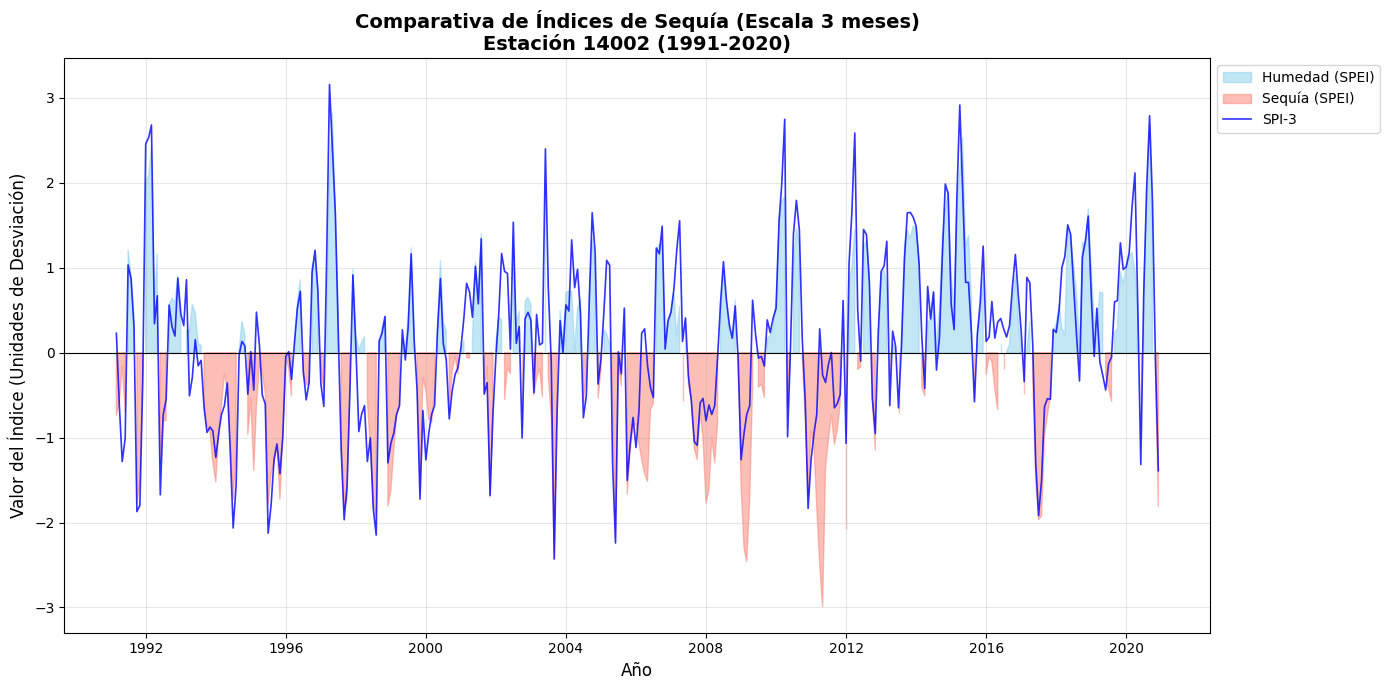

In [23]:
def graficar_comparativa_sequia(df, escala=3):
    # Crear la figura
    plt.figure(figsize=(14, 7), dpi=100)
    
    # Seleccionar las columnas según la escala (3 o 12)
    col_spi = f'SPI_{escala}'
    col_spei = f'SPEI_{escala}'
    
    # Graficar SPEI (Área sombreada)
    plt.fill_between(df.index, df[col_spei], 0, 
                     where=(df[col_spei] >= 0), color='skyblue', alpha=0.5, label='Humedad (SPEI)')
    plt.fill_between(df.index, df[col_spei], 0, 
                     where=(df[col_spei] < 0), color='salmon', alpha=0.5, label='Sequía (SPEI)')
    
    # Graficar SPI (Línea para contrastar)
    plt.plot(df.index, df[col_spi], color='blue', linewidth=1.2, label=f'SPI-{escala}', alpha=0.8)
    
    # Configuración de estilo
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    #plt.axhline(-1, color='orange', linestyle='--', linewidth=0.8, label='Sequía Moderada')
    #plt.axhline(-2, color='red', linestyle='--', linewidth=0.8, label='Sequía Extrema')
    
    # Títulos y etiquetas (Estilo institucional)
    plt.title(f'Comparativa de Índices de Sequía (Escala {escala} meses)\nEstación 14002 (1991-2020)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Valor del Índice (Unidades de Desviación)', fontsize=12)
    plt.xlabel('Año', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    # Guardar la gráfica para tu reporte
    plt.savefig(f'../02_OUTPUTS/_indices_ven{escala}14002_1991_2020.png', dpi=300)
    plt.show()

# --- EJECUTAR ---
# Graficamos la escala de 3 meses (Agrícola)
graficar_comparativa_sequia(df_mensual, escala=3)


#grafica_presentacion("../02_OUTPUTS/ven12/RESULTADOS_V12_SMN_14397_1991_2020.csv")


Para ventana de 12 meses

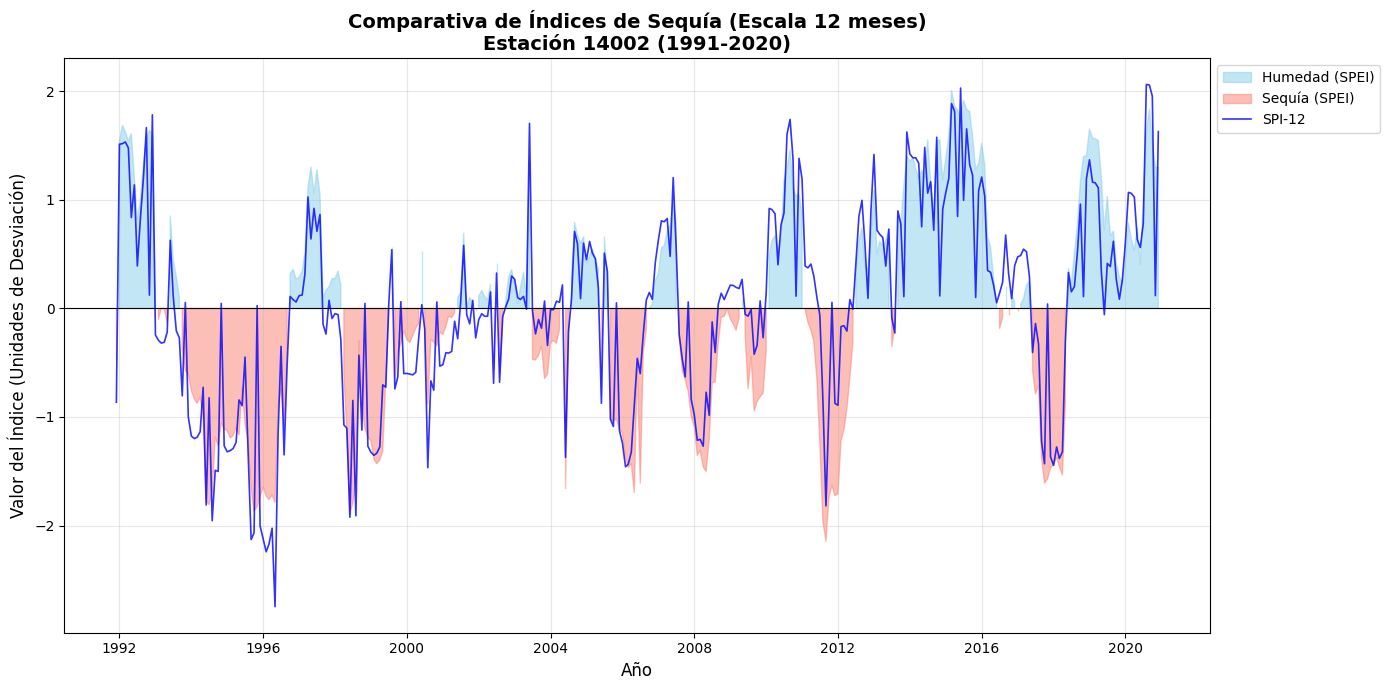

In [24]:
def graficar_comparativa_sequia(df, escala=12):
    # Crear la figura
    plt.figure(figsize=(14, 7), dpi=100)
    
    # Seleccionar las columnas según la escala (3 o 12)
    col_spi = f'SPI_{escala}'
    col_spei = f'SPEI_{escala}'
    
    # Graficar SPEI (Área sombreada)
    plt.fill_between(df.index, df[col_spei], 0, 
                     where=(df[col_spei] >= 0), color='skyblue', alpha=0.5, label='Humedad (SPEI)')
    plt.fill_between(df.index, df[col_spei], 0, 
                     where=(df[col_spei] < 0), color='salmon', alpha=0.5, label='Sequía (SPEI)')
    
    # Graficar SPI (Línea para contrastar)
    plt.plot(df.index, df[col_spi], color='blue', linewidth=1.2, label=f'SPI-{escala}', alpha=0.8)
    
    # Configuración de estilo
    plt.axhline(0, color='black', linestyle='-', linewidth=0.8)
    #plt.axhline(-1, color='orange', linestyle='--', linewidth=0.8, label='Sequía Moderada')
    #plt.axhline(-2, color='red', linestyle='--', linewidth=0.8, label='Sequía Extrema')
    
    # Títulos y etiquetas (Estilo institucional)
    plt.title(f'Comparativa de Índices de Sequía (Escala {escala} meses)\nEstación 14002 (1991-2020)', 
              fontsize=14, fontweight='bold')
    plt.ylabel('Valor del Índice (Unidades de Desviación)', fontsize=12)
    plt.xlabel('Año', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    
    # Guardar la gráfica para tu reporte
    plt.savefig(f'../02_OUTPUTS/_indices_ven{escala}14002_1991_2020.png', dpi=300)
    plt.show()

# --- EJECUTAR ---
# Graficamos la escala de 3 meses (Agrícola)
graficar_comparativa_sequia(df_mensual, escala=12)


#grafica_presentacion("../02_OUTPUTS/ven12/RESULTADOS_V12_SMN_14397_1991_2020.csv")
